<a href="https://colab.research.google.com/github/quickgrid/CodeLab/blob/master/computer_vision/Imagenette_Keras_Functional_MobileNetV2_Variable_Size_Image_Training%2C_Classification%2C_OpenCV_FrozenGraph%2C_TFlite_Inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# References:

https://medium.com/mindboard/image-classification-with-variable-input-resolution-in-keras-cbfbe576126f

https://github.com/opencv/opencv/issues/16582

https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/tools/freeze_graph.py

https://analyticsindiamag.com/transfer-learning-for-multi-class-image-classification-using-deep-convolutional-neural-network/

https://keras.io/guides/transfer_learning/

https://www.dlology.com/blog/how-to-convert-trained-keras-model-to-tensorflow-and-make-prediction/



```
TODO:
*   Add tflite saving and infernce
*   Save onnx and do opencv, onnx runtime inference
*   Find easier method convert into frozen graph
*   Add feature visualization
```







# Download and extract



In [ ]:
!wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz

--2020-09-08 08:14:38--  https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.145.29
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.145.29|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 98948031 (94M) [application/x-tar]
Saving to: ‘imagenette2-160.tgz’

imagenette2-160.tgz 100%[===================>]  94.36M  29.9MB/s    in 3.2s    

2020-09-08 08:14:42 (29.9 MB/s) - ‘imagenette2-160.tgz’ saved [98948031/98948031]



In [ ]:
import shutil
shutil.unpack_archive("imagenette2-160.tgz", "imagenette2")

# Import and define classes, batch, dataset path

In [44]:
#imports

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2,preprocess_input
from tensorflow.keras.applications.densenet import DenseNet121,preprocess_input
from tensorflow.keras.layers import Input,GlobalMaxPooling2D,Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array,load_img

from keras.preprocessing import image

from os import path, listdir
import numpy as np
from cv2 import resize
import cv2
from google.colab.patches import cv2_imshow


In [45]:
#initialize our generators; specifying data directories, batch size, and dimension threshold

train_image_directory = 'imagenette2/imagenette2-160/train'
test_image_directory = 'imagenette2/imagenette2-160/val'

n_classes = 10
batch_size = 16
max_dimension = 224

# Setup transfer learning model for different/variable size image training

In [46]:
#set up MobileNet GlobalMaxPooling and unsepcified input resolution

inputs = Input(shape=(None,None,3))


base_model = MobileNetV2(include_top=False, weights='imagenet', input_tensor=inputs)

#base_model = MobileNetV2(include_top=False, alpha=0.35, weights='imagenet', input_tensor=inputs, classes=n_classes)
#base_model = DenseNet121(include_top=False, weights='imagenet', input_tensor=inputs, classes=n_classes)

base_model.trainable = False

net = base_model(inputs, training=False)

#net = GlobalMaxPooling2D()(base_model.output)

net = keras.layers.GlobalAveragePooling2D()(net)

outputs = Dense(n_classes,activation='softmax')(net)

model = Model(inputs=inputs,outputs=outputs, name='imagenette_mobilenetv2')
model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])

In [47]:
model.summary()

Model: "imagenette_mobilenetv2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, None, None, 1280)  2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                12810     
Total params: 2,270,794
Trainable params: 12,810
Non-trainable params: 2,257,984
_________________________________________________________________


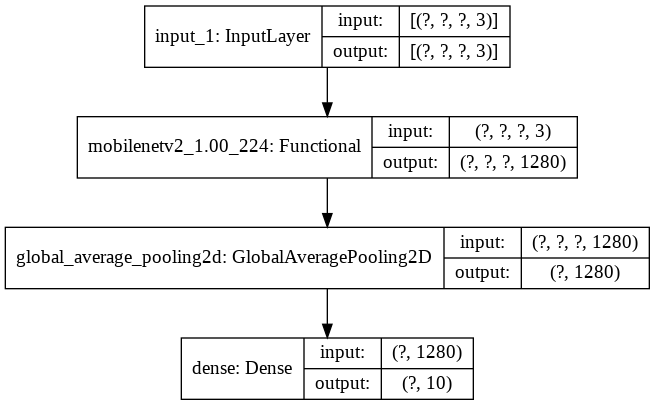

In [48]:
keras.utils.plot_model(model, "model1.png", show_shapes=True)

# Function for sorted image class, path retrival with image padding and batch 

In [49]:
#data generator class; yields batches of data for training/testing
global_class_true = []
class_true_list = []

class ImageGenerator():

    def __init__(self, directory, batch_size=16, shuffle=False, max_dimension=None):        
        
        self.directories = directory
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.max_dimension = max_dimension
        
        self.image_paths = []
        self.class_labels = []
        
        
        """
        Create list of image file paths and class target labels
        If sorted is not used the there may be label mis match
        """
        for class_label, class_dir in enumerate(sorted(listdir(directory))):
        
        #for class_label, class_dir in enumerate(listdir(directory)):
            #self.image_paths += [path.join(directory,class_dir,f) for f in listdir(path.join(directory,class_dir))]
            #self.class_labels += [class_label for _ in listdir(path.join(directory,class_dir))]
  
            """Get certain amount of files from directory for faster testing"""
            sample_count = 0
            unlimit_sample = True
            tmp1 = []
            tmp2 = []
            
            for f in listdir(path.join(directory,class_dir)):
                if unlimit_sample:
                    tmp1 += [path.join(directory,class_dir,f)] 
                    tmp2 += [class_label]
                else:
                  if sample_count < 100:
                      tmp1 += [path.join(directory,class_dir,f)] 
                      tmp2 += [class_label]

                      #tmp1.append(path.join(directory,class_dir,f))
                      #tmp2.append(class_label)
                  sample_count += 1
            self.image_paths += tmp1
            self.class_labels += tmp2
 


        self.image_paths = np.array(self.image_paths)
        self.class_labels = np.array(self.class_labels)

        global_class_true=self.class_labels
        class_true_list.append(global_class_true)
        print(global_class_true)
        print(len(global_class_true))

        #print(len(self.image_paths))
        #print(self.image_paths)
        #print(self.class_labels)
  

        #index array for shuffling data
        self.idx = np.arange(len(self.image_paths))

        #print(self.idx)
        
    
    def __len__(self):
        
        #number of batches in an epoch
        return int(np.ceil(len(self.image_paths)/float(self.batch_size)))
    
    
    def _load_image(self,img_path):
        
        #load image from path and convert to array
        img = load_img(img_path, color_mode='rgb', interpolation='nearest')
        img = img_to_array(img)
        
        #downsample image if above allowed size if specified
        max_dim = max(img.shape) 
        if self.max_dimension:
            if max_dim > self.max_dimension:
                new_dim = tuple(d*self.max_dimension//max_dim for d in img.shape[1::-1])
                img = resize(img, new_dim)
            
        #scale image values
        img = preprocess_input(img)

        return img
    
    
    def _pad_images(self,img,shape):
        #pad images to match largest image in batch
        img = np.pad(img,(*[((shape[i]-img.shape[i])//2,
                    ((shape[i]-img.shape[i])//2) + ((shape[i]-img.shape[i])%2)) for i in range(2)],
                          (0,0)),mode='constant',constant_values=0.)
        
        return img


    def __call__(self):
        #shuffle index
        if self.shuffle:
            np.random.shuffle(self.idx)
        
        #generate batches
        for batch in range(len(self)):

            batch_image_paths = self.image_paths[self.idx[batch*self.batch_size:(batch+1)*self.batch_size]]
            batch_class_labels = self.class_labels[self.idx[batch*self.batch_size:(batch+1)*self.batch_size]]

            batch_images = [self._load_image(image_path) for image_path in batch_image_paths]

            max_resolution = tuple(max([img.shape[i] for img in batch_images]) for i in range(2))
            batch_images = np.array([self._pad_images(image,max_resolution) for image in batch_images])

            yield batch_images, batch_class_labels

# Create train, test data and fit

In [50]:
#create generators for training and generating
train_generator = ImageGenerator(train_image_directory, batch_size=batch_size, shuffle=True, max_dimension=max_dimension)
test_generator = ImageGenerator(test_image_directory, batch_size=batch_size, max_dimension=max_dimension)

#convert generators into tf.data.Dataset objects for optimization with keras model fit method

train_dataset = tf.data.Dataset.from_generator(train_generator,
     (tf.float32, tf.int32),
    (tf.TensorShape([None,None,None,3]), tf.TensorShape([None])))

test_dataset = tf.data.Dataset.from_generator(test_generator,
     (tf.float32, tf.int32),
    (tf.TensorShape([None,None,None,3]), tf.TensorShape([None])))


#train and evaluate model

#model.fit(train_dataset,validation_data=test_dataset,epochs=10,verbose=1,workers=2,max_queue_size=20)
#model.fit(train_dataset,validation_data=test_dataset,epochs=5,verbose=1,workers=2,max_queue_size=20)

model.fit(train_dataset,validation_data=test_dataset,epochs=1,verbose=1,workers=2,max_queue_size=20)
#model.fit(train_dataset,validation_data=test_dataset,epochs=1,verbose=1)

[0 0 0 ... 9 9 9]
9469
[0 0 0 ... 9 9 9]
3925
592/592 [==============================] - 65s 110ms/step - loss: 0.3031 - sparse_categorical_accuracy: 0.9138 - val_loss: 0.1780 - val_sparse_categorical_accuracy: 0.9439


# Save and reload the model.

In [51]:
model.save("Imagenette_mobilenetV2.h5")

# It can be used to reconstruct the model identically.
reconstructed_model = keras.models.load_model("Imagenette_mobilenetV2.h5")

In [52]:
#importing other required libraries
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [53]:
#Defining function for confusion matrix plot
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):

    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    #Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#print(cm)

    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')


    #Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)

In [55]:
y_pred=model.predict(test_dataset)
y_pred=np.argmax(y_pred,axis=1)

print(y_pred)

[0 0 0 ... 5 9 9]


Confusion matrix, without normalization


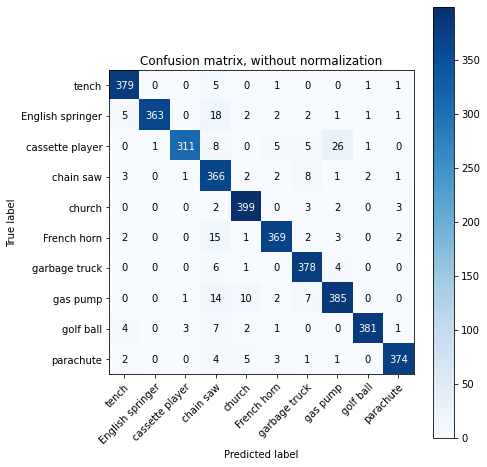

In [56]:
#Plotting the confusion matrix
y_true = class_true_list[1]

confusion_mtx = confusion_matrix(y_true, y_pred)

#Defining the class labels
class_names = ['tench', 'English springer', 'cassette player', 'chain saw', 'church', 'French horn', 'garbage truck', 'gas pump', 'golf ball', 'parachute']

# Plotting non-normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes = class_names, title='Confusion matrix, without normalization')

# Perform single image inference with manual preprocessing

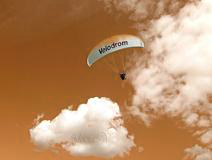

(160, 212, 3)
(1, 160, 212, 3)


In [57]:


#img_width, img_height = 150, 150
#img = image.load_img('imagenette2/imagenette2-160/train/n03445777/ILSVRC2012_val_00002314.JPEG', target_size = (img_width, img_height))

#img = image.load_img('imagenette2/imagenette2-160/train/n03445777/ILSVRC2012_val_00002314.JPEG')
img = image.load_img('imagenette2/imagenette2-160/train/n03888257/ILSVRC2012_val_00007616.JPEG')

#img = cv2.imread('imagenette2/imagenette2-160/train/n01440764/ILSVRC2012_val_00000293.JPEG')
#img = cv2.imread('imagenette2/imagenette2-160/train/n03417042/n03417042_11779.JPEG')
#img = cv2. cvtColor(img, cv2.COLOR_RGB2BGR) 

img = image.img_to_array(img)

cv2_imshow(img)


#img = cv2.resize(img, (224,224))

print(img.shape)

img = image.img_to_array(img)
img = np.expand_dims(img, axis = 0)


#img = preprocess_input(img)


"""
reverse rgb order, set float and normalize
importance of preprocessing can be seen if the line below is commented and prediction is run below
"""
#img = (img.astype(np.float32)) / 255.0
img = (img[...,::-1].astype(np.float32)) / 255.0


print(img.shape)



In [58]:
class_names = ['tench', 'English springer', 'cassette player', 'chain saw', 'church', 'French horn', 'garbage truck', 'gas pump', 'golf ball', 'parachute']

#class_names = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '0']

In [59]:
y_prob = reconstructed_model.predict(img)

print(y_prob)

#y_classes = y_prob.argmax(axis=-1)

y_classes = y_prob.argmax(axis=-1)

print(y_classes)

print(class_names[y_classes[0]])

[[8.67e-06 4.66e-06 2.45e-06 2.29e-05 1.70e-06 2.19e-06 4.14e-06 1.11e-05
  3.02e-05 1.00e+00]]
[9]
parachute


# Classify whole training or testing batch

In [60]:
#data generator class; yields batches of data for training/testing
global_class_true2 = []
class_true_list2 = []

class ImageGenerator2():

    def __init__(self, directory, batch_size=16, shuffle=False, max_dimension=None):        
        
        self.directories = directory
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.max_dimension = max_dimension
        
        self.image_paths = []
        self.class_labels = []
        
        
        """
        Create list of image file paths and class target labels
        If sorted is not used the there may be label mis match
        """
        for class_label, class_dir in enumerate(sorted(listdir(directory))):
        
        #for class_label, class_dir in enumerate(listdir(directory)):
            #self.image_paths += [path.join(directory,class_dir,f) for f in listdir(path.join(directory,class_dir))]
            #self.class_labels += [class_label for _ in listdir(path.join(directory,class_dir))]
  
            """Get certain amount of files from directory for faster testing"""
            sample_count = 0
            unlimit_sample = False
            tmp1 = []
            tmp2 = []
            
            for f in listdir(path.join(directory,class_dir)):
                if unlimit_sample:
                    tmp1 += [path.join(directory,class_dir,f)] 
                    tmp2 += [class_label]
                else:
                  if sample_count < 4:
                      tmp1 += [path.join(directory,class_dir,f)] 
                      tmp2 += [class_label]

                      #tmp1.append(path.join(directory,class_dir,f))
                      #tmp2.append(class_label)
                  sample_count += 1
            self.image_paths += tmp1
            self.class_labels += tmp2
 


        self.image_paths = np.array(self.image_paths)
        self.class_labels = np.array(self.class_labels)

        global_class_true2=self.class_labels
        class_true_list2.append(global_class_true2)
        print(global_class_true2)
        print(len(global_class_true2))

        print(len(self.image_paths))
        print(self.image_paths)
        print(self.class_labels)
  

        #index array for shuffling data
        self.idx = np.arange(len(self.image_paths))

        #print(self.idx)
        
    
    def __len__(self):
        
        #number of batches in an epoch
        return int(np.ceil(len(self.image_paths)/float(self.batch_size)))
    
    
    def _load_image(self,img_path):
        
        #load image from path and convert to array
        img = load_img(img_path, color_mode='rgb', interpolation='nearest')
        img = img_to_array(img)
        
        #downsample image if above allowed size if specified
        max_dim = max(img.shape) 
        if self.max_dimension:
            if max_dim > self.max_dimension:
                new_dim = tuple(d*self.max_dimension//max_dim for d in img.shape[1::-1])
                img = resize(img, new_dim)
            
        #scale image values
        img = preprocess_input(img)

        return img
    
    
    def _pad_images(self,img,shape):
        #pad images to match largest image in batch
        img = np.pad(img,(*[((shape[i]-img.shape[i])//2,
                    ((shape[i]-img.shape[i])//2) + ((shape[i]-img.shape[i])%2)) for i in range(2)],
                          (0,0)),mode='constant',constant_values=0.)
        
        return img


    def __call__(self):
        #shuffle index
        if self.shuffle:
            np.random.shuffle(self.idx)
        
        #generate batches
        for batch in range(len(self)):

            batch_image_paths = self.image_paths[self.idx[batch*self.batch_size:(batch+1)*self.batch_size]]
            batch_class_labels = self.class_labels[self.idx[batch*self.batch_size:(batch+1)*self.batch_size]]

            batch_images = [self._load_image(image_path) for image_path in batch_image_paths]

            max_resolution = tuple(max([img.shape[i] for img in batch_images]) for i in range(2))
            batch_images = np.array([self._pad_images(image,max_resolution) for image in batch_images])

            yield batch_images, batch_class_labels

In [61]:
train_generator2 = ImageGenerator2(train_image_directory, batch_size=batch_size, shuffle=False, max_dimension=max_dimension)
test_generator2 = ImageGenerator2(test_image_directory, batch_size=batch_size, max_dimension=max_dimension)

#convert generators into tf.data.Dataset objects for optimization with keras model fit method

train_dataset2 = tf.data.Dataset.from_generator(train_generator2,
     (tf.float32, tf.int32),
    (tf.TensorShape([None,None,None,3]), tf.TensorShape([None])))

test_dataset2 = tf.data.Dataset.from_generator(test_generator2,
     (tf.float32, tf.int32),
    (tf.TensorShape([None,None,None,3]), tf.TensorShape([None])))


[0 0 0 0 1 1 1 1 2 2 2 2 3 3 3 3 4 4 4 4 5 5 5 5 6 6 6 6 7 7 7 7 8 8 8 8 9
 9 9 9]
40
40
['imagenette2/imagenette2-160/train/n01440764/n01440764_6468.JPEG'
 'imagenette2/imagenette2-160/train/n01440764/n01440764_8134.JPEG'
 'imagenette2/imagenette2-160/train/n01440764/n01440764_10514.JPEG'
 'imagenette2/imagenette2-160/train/n01440764/n01440764_1735.JPEG'
 'imagenette2/imagenette2-160/train/n02102040/n02102040_3586.JPEG'
 'imagenette2/imagenette2-160/train/n02102040/n02102040_6196.JPEG'
 'imagenette2/imagenette2-160/train/n02102040/n02102040_2318.JPEG'
 'imagenette2/imagenette2-160/train/n02102040/n02102040_2598.JPEG'
 'imagenette2/imagenette2-160/train/n02979186/ILSVRC2012_val_00027673.JPEG'
 'imagenette2/imagenette2-160/train/n02979186/n02979186_237.JPEG'
 'imagenette2/imagenette2-160/train/n02979186/n02979186_5947.JPEG'
 'imagenette2/imagenette2-160/train/n02979186/n02979186_10523.JPEG'
 'imagenette2/imagenette2-160/train/n03000684/n03000684_35223.JPEG'
 'imagenette2/imagenette2-160

In [62]:
y_pred=model.predict(test_dataset2)
y_pred=np.argmax(y_pred,axis=1)

print(y_pred)

[0 0 0 0 1 1 1 1 5 2 7 2 3 3 3 3 4 4 4 6 5 5 5 5 6 6 6 6 7 7 7 7 8 8 8 8 9
 9 9 9]


Confusion matrix, without normalization


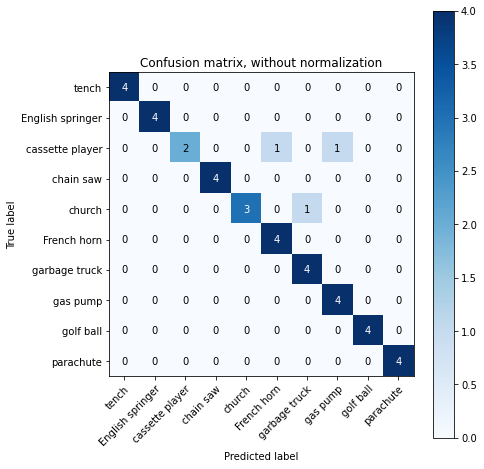

In [63]:
#Plotting the confusion matrix
y_true = class_true_list2[1]

confusion_mtx = confusion_matrix(y_true, y_pred)

#Defining the class labels
class_names = ['tench', 'English springer', 'cassette player', 'chain saw', 'church', 'French horn', 'garbage truck', 'gas pump', 'golf ball', 'parachute']

# Plotting non-normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes = class_names, title='Confusion matrix, without normalization')

# Single image inference

In [399]:
## Download some new images from net for inference

!wget 'http://c.shld.net/rpx/i/s/i/spin/image/spin_prod_208550001?hei=333&amp;wid=333&amp;op_sharpen=1' -O 'chainsaw1.jpg'
!wget 'https://i.ytimg.com/vi/LTUjiLxzDQs/maxresdefault.jpg' -O 'garbagetruck1.jpg'

--2020-09-08 13:23:27--  http://c.shld.net/rpx/i/s/i/spin/image/spin_prod_208550001?hei=333&amp;wid=333&amp;op_sharpen=1
Resolving c.shld.net (c.shld.net)... 88.221.165.174
Connecting to c.shld.net (c.shld.net)|88.221.165.174|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22382 (22K) [image/jpeg]
Saving to: ‘chainsaw1.jpg’

chainsaw1.jpg       100%[===================>]  21.86K  --.-KB/s    in 0.005s  

2020-09-08 13:23:27 (4.68 MB/s) - ‘chainsaw1.jpg’ saved [22382/22382]

--2020-09-08 13:23:27--  https://i.ytimg.com/vi/LTUjiLxzDQs/maxresdefault.jpg
Resolving i.ytimg.com (i.ytimg.com)... 74.125.133.119, 2a00:1450:400c:c07::77
Connecting to i.ytimg.com (i.ytimg.com)|74.125.133.119|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 161093 (157K) [image/jpeg]
Saving to: ‘garbagetruck1.jpg’

garbagetruck1.jpg   100%[===================>] 157.32K  --.-KB/s    in 0.002s  

2020-09-08 13:23:27 (98.4 MB/s) - ‘garbagetruck1.jpg’ saved [161093/161

In [64]:
def _load_image(img_path):
    
    #load image from path and convert to array
    img = load_img(img_path, color_mode='rgb', interpolation='nearest')
    img = img_to_array(img)
    
    #downsample image if above allowed size if specified
    max_dim = max(img.shape) 
    if max_dimension:
        if max_dim > max_dimension:
            new_dim = tuple(d*max_dimension//max_dim for d in img.shape[1::-1])
            img = resize(img, new_dim)
        
    #scale image values
    img = preprocess_input(img)

    return img


def _pad_images(img,shape):
    #pad images to match largest image in batch
    img = np.pad(img,(*[((shape[i]-img.shape[i])//2,
                ((shape[i]-img.shape[i])//2) + ((shape[i]-img.shape[i])%2)) for i in range(2)],
                      (0,0)),mode='constant',constant_values=0.)
    
    return img

(224, 224)
(224, 224, 3)


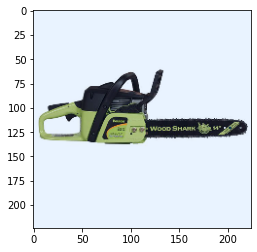

In [65]:
## Point to image, resize keeping aspect ratio and pad rest

image_paths = ['chainsaw1.jpg']


batch_images = [_load_image(image_paths[0])]
max_resolution = tuple(max([batch_images[0].shape[i]]) for i in range(2))


print(max_resolution)


batch_images = np.array([_pad_images(batch_images[0],max_resolution)])
test_dataset = batch_images


## Show the image

print(test_dataset[0].shape)

from keras.preprocessing.image import array_to_img
rgb = array_to_img(test_dataset[0])

plt.imshow(rgb)

In [66]:
y_pred=model.predict(test_dataset)
y_pred=np.argmax(y_pred,axis=1)


print('Precited')
print(y_pred)
print(class_names[y_pred[0]])

Precited
[3]
chain saw


In [67]:
model.save('saved_model/my_model') 

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: saved_model/my_model/assets


In [1]:
pip install opencv-python --upgrade

Requirement already up-to-date: opencv-python in /usr/local/lib/python3.6/dist-packages (4.4.0.42)


In [68]:
# Convert Keras model to ConcreteFunction
model = tf.keras.models.load_model("Imagenette_mobilenetV2.h5")
full_model = tf.function(lambda x: model(x))
full_model = full_model.get_concrete_function(
    tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype))

# Get frozen ConcreteFunction
frozen_func = convert_variables_to_constants_v2(full_model)
frozen_func.graph.as_graph_def()

layers = [op.name for op in frozen_func.graph.get_operations()]
print("-" * 50)
print("Frozen model layers: ")
for layer in layers:
    print(layer)

print("-" * 50)
print("Frozen model inputs: ")
print(frozen_func.inputs)
print("Frozen model outputs: ")
print(frozen_func.outputs)

# Save frozen graph from frozen ConcreteFunction to hard drive
tf.io.write_graph(graph_or_graph_def=frozen_func.graph,
                  logdir="./frozen_models",
                  name="frozen_graph.pb",
                  as_text=False)

--------------------------------------------------
Frozen model layers: 
x
imagenette_mobilenetv2/mobilenetv2_1.00_224/Conv1_pad/Pad/paddings
imagenette_mobilenetv2/mobilenetv2_1.00_224/Conv1_pad/Pad
imagenette_mobilenetv2/mobilenetv2_1.00_224/Conv1/Conv2D/ReadVariableOp/resource
imagenette_mobilenetv2/mobilenetv2_1.00_224/Conv1/Conv2D/ReadVariableOp
imagenette_mobilenetv2/mobilenetv2_1.00_224/Conv1/Conv2D
imagenette_mobilenetv2/mobilenetv2_1.00_224/bn_Conv1/ReadVariableOp/resource
imagenette_mobilenetv2/mobilenetv2_1.00_224/bn_Conv1/ReadVariableOp
imagenette_mobilenetv2/mobilenetv2_1.00_224/bn_Conv1/ReadVariableOp_1/resource
imagenette_mobilenetv2/mobilenetv2_1.00_224/bn_Conv1/ReadVariableOp_1
imagenette_mobilenetv2/mobilenetv2_1.00_224/bn_Conv1/FusedBatchNormV3/ReadVariableOp/resource
imagenette_mobilenetv2/mobilenetv2_1.00_224/bn_Conv1/FusedBatchNormV3/ReadVariableOp
imagenette_mobilenetv2/mobilenetv2_1.00_224/bn_Conv1/FusedBatchNormV3/ReadVariableOp_1/resource
imagenette_mobilenetv

'./frozen_models/frozen_graph.pb'

In [20]:
!wget 'https://www.thetruthaboutcars.com/wp-content/uploads/2008/05/gas-pump-croppedpreview.jpg' -O 'gaspump1.jpg'

--2020-09-08 16:04:00--  https://www.thetruthaboutcars.com/wp-content/uploads/2008/05/gas-pump-croppedpreview.jpg
Resolving www.thetruthaboutcars.com (www.thetruthaboutcars.com)... 104.18.3.232, 104.18.2.232
Connecting to www.thetruthaboutcars.com (www.thetruthaboutcars.com)|104.18.3.232|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26764 (26K) [image/jpeg]
Saving to: ‘gaspump1.jpg’

gaspump1.jpg        100%[===================>]  26.14K  --.-KB/s    in 0s      

2020-09-08 16:04:00 (79.1 MB/s) - ‘gaspump1.jpg’ saved [26764/26764]



[INFO]img shape:  (1, 3, 224, 224)


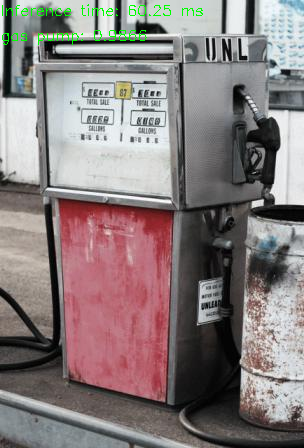

In [70]:
from cv2 import dnn
import numpy as np

#img_cv2 = cv2.imread('garbagetruck1.jpg')
#img_cv2 = cv2.imread('chainsaw1.jpg')
img_cv2 = cv2.imread('gaspump1.jpg')

inWidth = 224
inHeight = 224
blob = cv2.dnn.blobFromImage(img_cv2,
                                scalefactor=1.0 / 255,
                                size=(inWidth, inHeight),
                                mean=(0, 0, 0),
                                swapRB=False,
                                crop=False)

# blob = np.transpose(blob, (0,2,3,1)) 
print("[INFO]img shape: ", blob.shape)

net = dnn.readNetFromTensorflow('frozen_models/frozen_graph.pb')

# Run a model
net.setInput(blob)
out = net.forward()

# Get a class with a highest score.
out = out.flatten()
classId = np.argmax(out)
confidence = out[classId]

# Put efficiency information.
t, _ = net.getPerfProfile()
label = 'Inference time: %.2f ms' % (t * 1000.0 / cv2.getTickFrequency())
cv2.putText(img_cv2, label, (0, 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0))


classes = class_names
label = '%s: %.4f' % (classes[classId] if classes else 'Class #%d' % classId, confidence)
cv2.putText(img_cv2, label, (0, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0))

cv2.imwrite('catposter.jpg', img_cv2)

cv2_imshow(img_cv2)

# Setup tf2onnx for converting savedmodel or frozen model to onnx

In [25]:
!pip install -U tf2onnx

     |████████████████████████████████| 194kB 7.3MB/s 


In [31]:
!python -m tf2onnx.convert --opset 10 --fold_const --saved-model saved_model/my_model --output imagenette_savedmodel.onnx

2020-09-08 17:04:13.777185: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-09-08 17:04:15,489 - WARNING - '--tag' not specified for saved_model. Using --tag serve
2020-09-08 17:04:15.687202: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-09-08 17:04:15.690646: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-09-08 17:04:15.691496: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2020-09-08 17:04:15.691539: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic lib